🧴 Skin Type Detection Attempt (Day 3 Documentation)
 Introduction
In this phase, the goal was to build a skin condition detection model that could classify the user's skin into different categories using webcam input. The primary intention was to integrate this into a smart mirror PoC that promotes wellness feedback based on skin analysis. However, the ultimate vision wasn't medical diagnosis — instead, it was wellness-based suggestions (e.g., tired, dehydrated, irritated, healthy).

Initially, we approached the task by creating a CNN-based skin type classifier.

📊 Data Summary
Initial classes (6): acne, oily, dry, normal, red, bag under eyes

Each class had only ~35 images, so we used data augmentation to raise the count to ~200 images per class.

Model trained on this version showed high accuracy (~90%), and confusion matrix showed fewer than 5 misclassifications on validation data.

🛑 Issue: The model failed to predict accurately on real-world test images (downloaded from Google), highlighting generalization issues.

Instead of pursuing a skin classifier, we pivoted toward implementing a more meaningful and feasible feature:
Fatigue detection using eye aspect ratio (EAR) and wellness conversation triggers using LLMs and memory.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

import zipfile

zip_path = '/content/drive/MyDrive/Classroom/archive (5).zip'
extract_path = 'skin_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted to:", extract_path)


✅ Dataset extracted to: skin_dataset


In [ ]:
import os
import shutil

# Set root directory where your class folders are (after unzipping and flattening)
ROOT_DIR = "skin_dataset/files"  # adjust if different

# Loop through each class folder
for class_name in os.listdir(ROOT_DIR):
    class_path = os.path.join(ROOT_DIR, class_name)

    if not os.path.isdir(class_path):
        continue  # skip files

    # Move images from subfolders (if any) to the main class folder
    for root, dirs, files in os.walk(class_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                src = os.path.join(root, file)
                dst = os.path.join(class_path, file)

                # Rename if file already exists
                base, ext = os.path.splitext(file)
                counter = 1
                while os.path.exists(dst):
                    dst = os.path.join(class_path, f"{base}_{counter}{ext}")
                    counter += 1

                shutil.move(src, dst)

    # After moving, remove all subfolders
    for folder in os.listdir(class_path):
        folder_path = os.path.join(class_path, folder)
        if os.path.isdir(folder_path):
            shutil.rmtree(folder_path)

    print(f"✅ Cleaned: {class_name}")

print("✅ All class folders cleaned. Only images remain.")


✅ Cleaned: acne
✅ Cleaned: redness
✅ Cleaned: bags
✅ All class folders cleaned. Only images remain.


In [ ]:

import zipfile

zip_path = '/content/drive/MyDrive/Classroom/archive (6).zip'
extract_path = 'skin_dataset_2'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted to:", extract_path)

✅ Dataset extracted to: skin_dataset_2


In [ ]:
# STEP 1: Install Augmentor
!pip install Augmentor


In [ ]:
# STEP 2: Import Required Libraries
import Augmentor               # Main library for image augmentation
import os                     # For handling folder paths and files


In [ ]:
# STEP 3: Define dataset directory
# This is the folder that contains all your class folders
# /content/skin_dataset  contain subfolders like 'dry/', 'acne/', etc.

DATASET_PATH = "/content/skin_dataset"  #saving folder path


In [ ]:
# STEP 4: Define the classes and how many images you want per class
# We'll use 200 as the goal for each class

class_targets = {
    "dry": 200,
    "normal": 200,
    "oily": 200,
    "acne": 200,
    "redness": 200,
    "bags": 200
}




In [ ]:
from PIL import Image
import os

# Path to your dataset
DATASET_PATH = "/content/skin_dataset"  # change if needed

# Loop through all class folders
for class_name in os.listdir(DATASET_PATH):
    class_path = os.path.join(DATASET_PATH, class_name)
    if not os.path.isdir(class_path):
        continue

    # Loop through each image
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)

        try:
            with Image.open(img_path) as img:
                if img.mode != 'RGB':
                    rgb_img = img.convert('RGB')
                    rgb_img.save(img_path)  # Overwrite with RGB version
        except Exception as e:
            print(f"❌ Skipping {img_path}: {e}")

print("✅ All images converted to RGB.")


❌ Skipping /content/skin_dataset/acne/.ipynb_checkpoints: [Errno 21] Is a directory: '/content/skin_dataset/acne/.ipynb_checkpoints'
✅ All images converted to RGB.


In [ ]:
# STEP 5: Loop through each class folder, apply augmentations, and generate images

for class_name, target_count in class_targets.items():
    class_folder = os.path.join(DATASET_PATH, class_name)

    # Count existing images in this folder
    existing_images = len([
        name for name in os.listdir(class_folder)
        if name.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])

    print(f"🔍 Class: {class_name} | Existing: {existing_images} | Target: {target_count}")

    if existing_images >= target_count:
        print(f"✅ Skipping '{class_name}' — already has {existing_images} images.")
        continue  # Skip if class already has enough

    # Set up Augmentor pipeline for this class
    p = Augmentor.Pipeline(source_directory=class_folder, output_directory=class_folder)

    # Apply webcam-like augmentations
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)  # simulate head tilt
    p.flip_left_right(probability=0.5)                                     # simulate mirror flip
    p.random_brightness(probability=0.8, min_factor=0.5, max_factor=1.3)   # simulate poor lighting
    p.random_contrast(probability=0.5, min_factor=0.8, max_factor=1.4)     # simulate lighting shifts
    p.zoom(probability=0.5, min_factor=1.0, max_factor=1.3)                # mimic zoomed webcam
    p.random_distortion(probability=0.3, grid_width=4, grid_height=4, magnitude=2)
       # mimic low webcam quality

    # How many new samples do we need?
    to_generate = target_count - existing_images

    # Generate required number of images
    p.sample(to_generate)

    print(f"✅ Done: '{class_name}' now has ~{target_count} images.\n")


🔍 Class: dry | Existing: 76 | Target: 200
Initialised with 76 image(s) found.
Output directory set to /content/skin_dataset/dry.

Processing <PIL.Image.Image image mode=RGB size=183x275 at 0x786B70D42E90>: 100%|██████████| 124/124 [00:12<00:00,  9.78 Samples/s]


✅ Done: 'dry' now has ~200 images.

🔍 Class: normal | Existing: 35 | Target: 200
Initialised with 35 image(s) found.
Output directory set to /content/skin_dataset/normal.

Processing <PIL.Image.Image image mode=RGB size=736x433 at 0x786B70DF0750>: 100%|██████████| 165/165 [00:03<00:00, 41.67 Samples/s]


✅ Done: 'normal' now has ~200 images.

🔍 Class: oily | Existing: 39 | Target: 200
Initialised with 39 image(s) found.
Output directory set to /content/skin_dataset/oily.

Processing <PIL.Image.Image image mode=RGB size=256x197 at 0x786B70DE0050>: 100%|██████████| 161/161 [00:07<00:00, 21.10 Samples/s]


✅ Done: 'oily' now has ~200 images.

🔍 Class: acne | Existing: 30 | Target: 200
Initialised with 30 image(s) found.
Output directory set to /content/skin_dataset/acne.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x853 at 0x786B80573110>: 100%|██████████| 170/170 [03:33<00:00,  1.26s/ Samples]


✅ Done: 'acne' now has ~200 images.

🔍 Class: redness | Existing: 30 | Target: 200
Initialised with 30 image(s) found.
Output directory set to /content/skin_dataset/redness.

Processing <PIL.Image.Image image mode=RGB size=2448x3264 at 0x786B701A3CD0>: 100%|██████████| 170/170 [04:48<00:00,  1.70s/ Samples]


✅ Done: 'redness' now has ~200 images.

🔍 Class: bags | Existing: 30 | Target: 200
Initialised with 30 image(s) found.
Output directory set to /content/skin_dataset/bags.

Processing <PIL.Image.Image image mode=RGB size=3880x5184 at 0x786B80673C10>: 100%|██████████| 170/170 [04:27<00:00,  1.58s/ Samples]

✅ Done: 'bags' now has ~200 images.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil

# Move your dataset to your Google Drive folder
shutil.move("/content/skin_dataset", "/content/drive/MyDrive/Classroomskin_dataset")


'/content/drive/MyDrive/Classroomskin_dataset'

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/skin_dataset"

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Use your existing dataset path
SOURCE_DIR = DATASET_PATH
TARGET_DIR = "/content/skin_dataset_final"

# List class folders only
classes = [cls for cls in os.listdir(SOURCE_DIR) if os.path.isdir(os.path.join(SOURCE_DIR, cls))]

# Create train/val/test folders
for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(TARGET_DIR, split, cls), exist_ok=True)

# Loop through each class and process
for cls in classes:
    class_path = os.path.join(SOURCE_DIR, cls)

    # Get list of image files only
    img_list = [
        f for f in os.listdir(class_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

    # Skip if folder is empty
    if len(img_list) == 0:
        print(f"⚠️ Skipping {cls} — no images found.")
        continue

    # Split: 15% test → then 15% val from train_val
    train_val_imgs, test_imgs = train_test_split(img_list, test_size=0.15, random_state=42)
    train_imgs, val_imgs = train_test_split(train_val_imgs, test_size=0.15, random_state=42)

    # Copy to structured folders
    for img_name in train_imgs:
        shutil.copy(os.path.join(class_path, img_name), os.path.join(TARGET_DIR, 'train', cls, img_name))

    for img_name in val_imgs:
        shutil.copy(os.path.join(class_path, img_name), os.path.join(TARGET_DIR, 'val', cls, img_name))

    for img_name in test_imgs:
        shutil.copy(os.path.join(class_path, img_name), os.path.join(TARGET_DIR, 'test', cls, img_name))

    print(f"✅ {cls}: Train={len(train_imgs)}, Val={len(val_imgs)}, Test={len(test_imgs)}")


⚠️ Skipping .ipynb_checkpoints — no images found.
✅ dry: Train=144, Val=26, Test=30
✅ normal: Train=144, Val=26, Test=30
✅ oily: Train=144, Val=26, Test=30
✅ acne: Train=144, Val=26, Test=30
✅ redness: Train=144, Val=26, Test=30
✅ bags: Train=144, Val=26, Test=30


In [ ]:
def count_images(folder):
    return sum(len(files) for _, _, files in os.walk(folder))

print("\n📦 Final image counts:")
print("Train:", count_images(os.path.join(TARGET_DIR, 'train')))
print("Val:  ", count_images(os.path.join(TARGET_DIR, 'val')))
print("Test: ", count_images(os.path.join(TARGET_DIR, 'test')))



📦 Final image counts:
Train: 864
Val:   156
Test:  180


In [ ]:
DATASET_PATH = "/content/skin_dataset_final"
IMG_SIZE = 128
BATCH_SIZE = 32


In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    DATASET_PATH + "/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    DATASET_PATH + "/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = datagen.flow_from_directory(
    DATASET_PATH + "/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 864 images belonging to 7 classes.
Found 156 images belonging to 7 classes.
Found 180 images belonging to 7 classes.


In [ ]:
model = Sequential()

# 1st Conv Block
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

# 2nd Conv Block
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# 3rd Conv Block
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten → Dense Layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # helps prevent overfitting
model.add(Dense(train_gen.num_classes, activation='softmax'))  # output layer


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.1487 - loss: 1.8743 - val_accuracy: 0.4103 - val_loss: 1.6759
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.3321 - loss: 1.6429 - val_accuracy: 0.5641 - val_loss: 1.3557
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4657 - loss: 1.3605 - val_accuracy: 0.5256 - val_loss: 1.1455
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4876 - loss: 1.2068 - val_accuracy: 0.6282 - val_loss: 1.0181
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5371 - loss: 1.1272 - val_accuracy: 0.6218 - val_loss: 0.9919
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5799 - loss: 1.0635 - val_accuracy: 0.6603 - val_loss: 0.9115
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6135 - loss: 0.9612 - val_accuracy: 0.6410 - val_loss: 0.8968
Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6010 - loss: 0.9209 - val_accuracy: 0.6218 - val_loss:

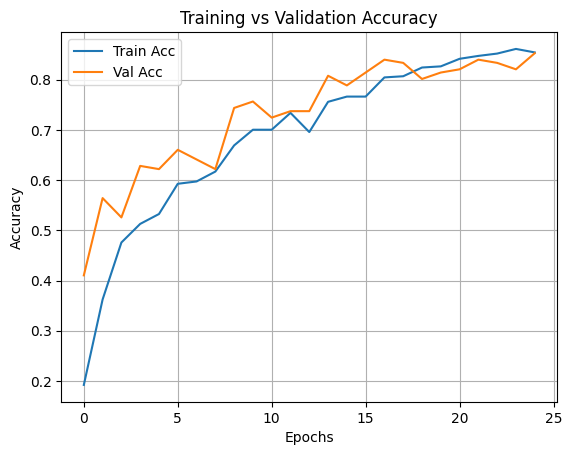

In [ ]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
loss, acc = model.evaluate(test_gen)
print(f"✅ Final Test Accuracy: {acc:.2f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
# Get true labels
true_labels = test_gen.classes

# Predict probabilities for each image
pred_probs = model.predict(test_gen, verbose=1)

# Get predicted class index
pred_labels = np.argmax(pred_probs, axis=1)

# Map class indices to class labels (dry, oily, etc.)
class_names = list(test_gen.class_indices.keys())


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 769ms/step


In [ ]:
cm = confusion_matrix(true_labels, pred_labels)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


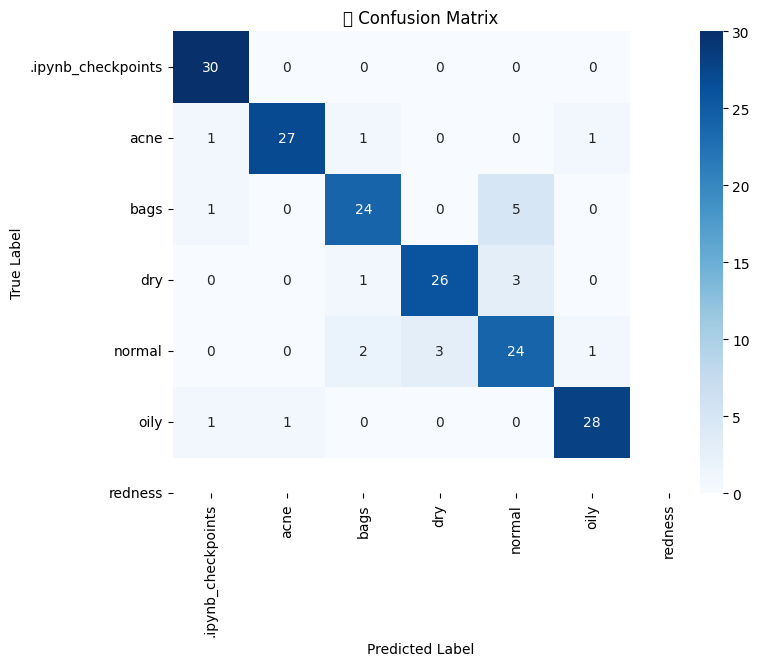

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("📊 Confusion Matrix")
plt.show()


In [ ]:
model.save("skin_type_model.h5")
print("✅ Model saved successfully!")


✅ Model saved successfully!


Saving dark circles.jpeg to dark circles.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step

🧠 Predicted: REDNESS (54.35% confidence)
💡 Tip: Use fragrance-free, soothing products.


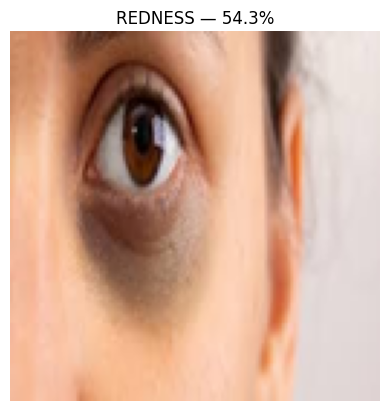

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image
from google.colab import files

# --- Load your trained model ---
model = load_model("skin_type_model.h5")  # Make sure it's uploaded

# --- Define class names and tips ---
class_names = sorted(["acne", "bags", "dry", "normal", "oily", "redness"])
tips = {
    "acne": "Try a gentle cleanser and avoid touching your face.",
    "bags": "You might be tired – rest & hydrate!",
    "dry": "Use moisturizer and drink plenty of water.",
    "normal": "Looks good – maintain your current routine.",
    "oily": "Blotting paper or mild wash may help shine.",
    "redness": "Use fragrance-free, soothing products."
}

# --- Upload an image ---
uploaded = files.upload()

for fname in uploaded.keys():
    img = Image.open(fname).convert("RGB")
    img = img.resize((128, 128))  # same as training input size
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # --- Predict ---
    preds = model.predict(img_array)
    pred_idx = np.argmax(preds)
    label = class_names[pred_idx]
    confidence = preds[0][pred_idx]

    # --- Show result ---
    print(f"\n🧠 Predicted: {label.upper()} ({confidence:.2%} confidence)")
    print("💡 Tip:", tips.get(label, "Take care of your skin."))

    plt.imshow(img)
    plt.title(f"{label.upper()} — {confidence:.1%}")
    plt.axis("off")
    plt.show()
